# Soft Binary Neural Network with Recurrent Forward Pass Layers for Crossbars

## Imports and Dataset

In [280]:
import numpy as np
import torch
import cv2 as cv
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os
from torchinfo import summary
import ast
import pandas as pd

In [281]:
def plot_history(history, num_epochs, element):
    epochs = range(len(history[list(history.keys())[0]]))
    
    fig, ax1 = plt.subplots(figsize=(12, 8))
    
    ax1.plot(epochs, history["train_loss"], label="Train Loss", color="blue")
    ax1.plot(epochs, history["val_loss"], label="Validation Loss", color="red")
    ax1.set_xlabel("Epochs", fontsize=14)
    ax1.set_ylabel("Loss", fontsize=14, color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")
    ax1.legend(loc="upper left")
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(epochs, history["train_accuracy"], label="Train Accuracy", color="green")
    ax2.plot(epochs, history["val_accuracy"], label="Validation Accuracy", color="orange")
    ax2.set_ylabel("Accuracy (%)", fontsize=14, color="green")
    ax2.tick_params(axis="y", labelcolor="green")
    ax2.legend(loc="upper right")

    plt.title(f"Training and Validation Metrics for {element}", fontsize=16)
    plt.tight_layout()
    plt.show()

In [282]:
A_true = np.array([
    [[0,1,1,0], [1,0,0,1], [1,1,1,1], [1,0,0,1]], 
    [[1,1,1,1], [1,0,0,1], [1,1,1,1], [1,0,0,1]], 
    [[0,1,1,0], [1,0,0,1], [1,1,1,1], [0,0,0,1]],
    [[1,1,1,1], [1,0,0,1], [1,1,1,1], [0,0,0,1]],
    [[0,1,1,0], [1,0,0,1], [1,1,1,1], [1,0,0,0]],
    [[1,1,1,1], [1,0,0,1], [1,1,1,1], [1,0,0,0]],
    [[0,1,0,0], [1,0,1,0], [1,1,1,0], [1,0,1,0]],
    [[0,0,1,0], [0,1,0,1], [0,1,1,1], [0,1,0,1]],
    [[1,1,1,0], [1,0,1,0], [1,1,1,0], [1,0,1,0]],
    [[0,1,1,1], [0,1,0,1], [0,1,1,1], [0,1,0,1]]])

T_true = np.array([
    [[1,1,1,1], [0,1,0,0], [0,1,0,0], [0,1,0,0]],
    [[1,1,1,1], [0,0,1,0], [0,0,1,0], [0,0,1,0]],
    [[1,1,1,0], [0,1,0,0], [0,1,0,0], [0,1,0,0]],
    [[0,1,1,1], [0,0,1,0], [0,0,1,0], [0,0,1,0]],
    [[1,1,1,1], [0,1,0,0], [0,1,0,0], [0,0,0,0]],
    [[1,1,1,1], [0,0,1,0], [0,0,1,0], [0,0,0,0]],
    [[1,1,1,0], [0,1,0,0], [0,1,0,0], [0,0,0,0]],
    [[0,1,1,1], [0,0,1,0], [0,0,1,0], [0,0,0,0]],
    [[0,0,0,0], [1,1,1,0], [0,1,0,0], [0,1,0,0]],
    [[0,0,0,0], [0,1,1,1], [0,0,1,0], [0,0,1,0]]])

V_true = np.array([
    [[1,0,0,1], [1,0,0,1], [1,0,0,1], [1,1,1,1]],
    [[1,0,0,1], [1,0,0,1], [1,0,0,1], [0,1,1,0]],
    [[1,0,1,0], [1,0,1,0], [1,0,1,0], [0,1,0,0]],
    [[0,1,0,1], [0,1,0,1], [0,1,0,1], [0,0,1,0]],
    [[0,0,0,0], [1,0,0,1], [1,0,0,1], [0,1,1,0]],
    [[0,0,0,0], [1,0,1,0], [1,0,1,0], [0,1,0,0]],
    [[0,0,0,0], [0,1,0,1], [0,1,0,1], [0,0,1,0]],
    [[1,0,1,0], [1,0,1,0], [0,1,0,0], [0,0,0,0]],
    [[0,1,0,1], [0,1,0,1], [0,0,1,0], [0,0,0,0]],
    [[1,0,0,1], [1,0,0,1], [0,1,1,0], [0,0,0,0]]])

X_true = np.array([
    [[1,0,1,0], [0,1,0,0], [1,0,1,0], [0,0,0,0]],
    [[0,0,0,0], [0,1,0,1], [0,0,1,0], [0,1,0,1]],
    [[0,0,0,0], [1,0,1,0], [0,1,0,0], [1,0,1,0]],
    [[0,1,0,1], [0,0,1,0], [0,1,0,1], [0,0,0,0]],
    [[1,0,1,0], [0,1,0,0], [1,0,1,0], [0,0,0,1]],
    [[1,0,0,0], [0,1,0,1], [0,0,1,0], [0,1,0,1]],
    [[0,0,0,1], [1,0,1,0], [0,1,0,0], [1,0,1,0]],
    [[0,1,0,1], [0,0,1,0], [0,1,0,1], [1,0,0,0]],
    [[0,1,0,1], [0,0,1,0], [0,1,0,1], [0,1,0,1]],
    [[1,0,1,0], [1,0,1,0], [0,1,0,0], [1,0,1,0]]])

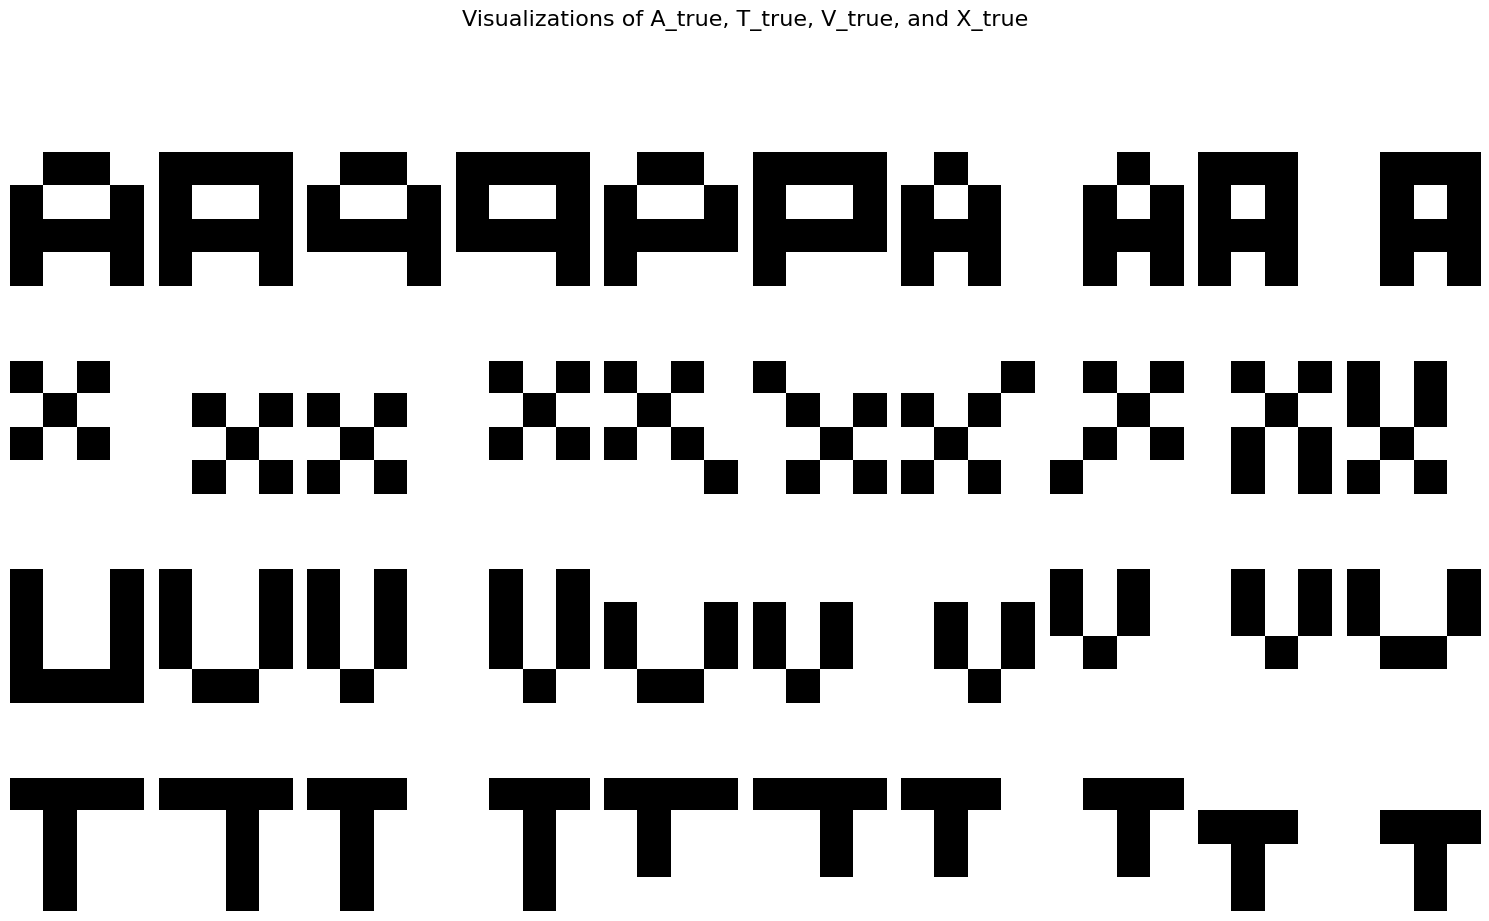

In [283]:
total_subplots = 4 * len(A_true)
fig, axes = plt.subplots(4, len(A_true), figsize=(15, 10))
fig.suptitle("Visualizations of A_true, T_true, V_true, and X_true", fontsize=16)

data_arrays = {"A": A_true, "X": X_true, "V": V_true, "T": T_true}

for row, (name, array) in enumerate(data_arrays.items()):
    for col in range(array.shape[0]):
        ax = axes[row, col]
        ax.imshow(1 - array[col], cmap="gray")
        ax.axis('off')
        if col == 0:
            ax.set_ylabel(name, fontsize=12)
        if row == len(data_arrays) - 1:
            ax.set_xlabel(f"Slice {col+1}", fontsize=10)

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust space for the suptitle
plt.show()

### Validation Set

In [284]:
AUG = np.zeros((4, 160, 4, 4), dtype=np.uint8)
for idx, data in enumerate([A_true, T_true, V_true, X_true]):
    for sample in range(10):
        AUG[idx][sample * 16:(sample + 1) * 16] = data[sample]
        for i in range(4):
            for j in range(4):
                AUG[idx][sample * 16 + 4 * i + j][i][j] ^= 1  # Flip bits (abs(x-1))

A_AUG, T_AUG, V_AUG, X_AUG = AUG

val_inputs = torch.tensor(np.concatenate([A_AUG, X_AUG, V_AUG, T_AUG]), dtype=torch.float32)
val_labels = torch.tensor(
    np.concatenate([[i] * len(AUG[i]) for i in range(4)]), dtype=torch.long
)
val_labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

### Training Set

In [285]:
A_true_tensor = torch.tensor(A_true, dtype=torch.float32)
X_true_tensor = torch.tensor(X_true, dtype=torch.float32)
V_true_tensor = torch.tensor(V_true, dtype=torch.float32)
T_true_tensor = torch.tensor(T_true, dtype=torch.float32)

train_inputs = torch.cat([A_true_tensor, X_true_tensor, V_true_tensor, T_true_tensor], dim=0)

num_samples_per_category = len(A_true)
train_labels = torch.cat([
    torch.full((num_samples_per_category,), 0, dtype=torch.long),
    torch.full((num_samples_per_category,), 1, dtype=torch.long),
    torch.full((num_samples_per_category,), 2, dtype=torch.long),
    torch.full((num_samples_per_category,), 3, dtype=torch.long),
])

In [286]:
train_labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

## Custom Neural Network

In [300]:
def tensor_stats(tensor, name="Tensor"):
    mean_magnitude = tensor.abs().mean().item()
    print(f"{name} - Mean Magnitude: {mean_magnitude:.2e}, Max: {tensor.max().item():.2e}, Min: {tensor.min().item():.2e}")
    
class SoftBinaryRecurrentForwardNetwork(nn.Module):
    def __init__(self, G_ON, G_OFF, V_INV, R_INV, V_1, V_0, zeta, initial_factor, 
                 crossbar=(8,8), input_size=16, recurrence_size=4, output_size=4, 
                 hidden_layers=2, verbose=False, monitor=True, dropout=0.2, int_lr = 0.01):
        super(SoftBinaryRecurrentForwardNetwork, self).__init__()

        # Crossbar Weights
        self.w = nn.Parameter(torch.empty(crossbar))
        nn.init.xavier_uniform_(self.w)
        self.w.data = initial_factor * self.w
        
        # Circuit Parameters
        self.G_ON = G_ON
        self.G_OFF = G_OFF
        self.V_INV = V_INV
        self.R_INV = R_INV
        self.V_1 = V_1
        self.V_0 = V_0

        # Architecture Parameters
        self.feedback = recurrence_size
        self.data_in = crossbar[0] - recurrence_size
        self.output_size = output_size
        self.crossbar_in = crossbar[0]
        self.crossbar_out = crossbar[1]
        self.h_layers = hidden_layers
        self.r_passes = input_size // self.data_in
        
        # Training Variables
        self.zeta = zeta
        self.verbose = verbose
        self.monitor = monitor
        self.dropout = nn.Dropout(p=dropout)
        self.int_lr = int_lr

    def INV_AMP(self, x):
        return -self.V_INV * torch.tanh(self.R_INV * x / self.V_INV)

    def SOFT_BIN(self, x):
        return ((self.G_ON - self.G_OFF) * torch.sigmoid(x * self.zeta) + self.G_OFF)

    def PREPROCESS(self, img):
        return (self.V_1 - self.V_0) * img.view(img.size(0), -1) + self.V_0

    def forward(self, img):
        # Preprocessing: Two States of input (V_ON and V_OFF)
        img = self.PREPROCESS(img)

        # RRAM Soft Binarization
        g = self.SOFT_BIN(self.w).to(img.device)
        
        if self.verbose:
            tensor_stats(self.w, "Latent Weights:")
            tensor_stats(g, "Soft Binarized Weights:")
        
        # Recurrent Forward Layer
        feedback = self.PREPROCESS(torch.zeros((img.shape[0],self.feedback))).to(img.device)
        
        for r_pass in range(self.r_passes):
            x = torch.cat((feedback, img[:, r_pass * self.data_in:(r_pass + 1) * self.data_in]), dim=1)
            x = F.linear(x, g, bias=None)
            x = self.INV_AMP(x)
            if self.verbose: tensor_stats(x,f"Voltages in Recurrent Stage after pass {r_pass}")
            feedback = x[:,-self.feedback:]

        x = self.dropout(x)
        
        # Hidden Layers
        for h_pass in range(self.h_layers):
            x = F.linear(x, g, bias=None)
            x = self.INV_AMP(x)
            if self.verbose: tensor_stats(x,f"Voltages after h_layer {h_pass}")
            x = self.dropout(x)

        # Output Classes
        return x[:,:self.output_size]
        
    def backprop(self, ext_lr):
        with torch.no_grad():
            if self.w.grad is not None:
                grad = self.w.grad
                grad = self.int_lr*grad/torch.norm(grad)
                if self.monitor: tensor_stats(grad, "Gradients")
                self.w -= ext_lr*grad
                self.w.grad.zero_()

In [301]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()  

In [302]:
class AugmentedDataset(Dataset):
    def __init__(self, images, labels, noise_std=0.1):
        self.images = images
        self.labels = labels
        self.noise_std = noise_std

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        noisy_image = image + torch.randn_like(image) * self.noise_std
        return noisy_image, label

## Model Parameters

In [310]:
params_RRAM = {
    "G_ON": 5.5e-5,          # High conductance state
    "G_OFF": 2.88e-6,        # Low conductance state
    "V_INV": 0.6,            # Inverter voltage
    "R_INV": 2e+3,         # Inverter resistance
    "V_1": 0.1,              # High input voltage
    "V_0": -0.1,             # Low input voltage
    "zeta": 100,               # Sharpness parameter for soft binarization 
    "initial_factor": 0.001,   # Initial weight scaling factor
    "crossbar": (8, 8),      # Crossbar size (rows, columns)
    "input_size": 16,        # Input size
    "recurrence_size": 4,    # Feedback size for recurrent connections
    "output_size": 4,        # Output size
    "hidden_layers": 0,      # Number of hidden layers 
    "verbose": False,        # Debugging flag
    "monitor": False,        # Monitoring flag
    "dropout": 0.2,          # Dropout probability 
    "noise_std": 0.04,        # Noise in Data Augmentation 
    "batch_size": 80,         # Training Batch Size 
    "lr": 0.1,            # Training LR
    "epochs": 1000,          # Training Epochs
    "int_lr": 0.01           # Internal LR
}

model_params = {k: v for k, v in params_RRAM.items() if k not in ["noise_std", "batch_size", "lr", "epochs"]}

model_RRAM = SoftBinaryRecurrentForwardNetwork(**model_params).to(device)
summary(model_RRAM)

Layer (type:depth-idx)                   Param #
SoftBinaryRecurrentForwardNetwork        64
├─Dropout: 1-1                           --
Total params: 64
Trainable params: 64
Non-trainable params: 0

In [311]:
augmented_dataset = AugmentedDataset(train_inputs, train_labels, noise_std=params_RRAM["noise_std"])
dataloader = DataLoader(augmented_dataset, batch_size=params_RRAM["batch_size"], shuffle=True)

### Loading Past Best Model

In [312]:
try:
    with open("Best_Val_Accuracy.txt", 'r') as f: val_best = float(f.read())
    with open("Best_Params.txt", 'r') as f: params_best = ast.literal_eval(f.read())
    checkpoint = torch.load("Best_model.pth")

    model_best = SoftBinaryRecurrentForwardNetwork(**model_params).to(device)
    model_best.load_state_dict(checkpoint)

    print("Accuracy:", val_best)
    print("Parameters:", params_best)

except Exception as e:
    print(e)
    val_best = 0
    print("No Saved Model")

Accuracy: 60.625
Parameters: {'G_ON': 5.5e-05, 'G_OFF': 2.88e-06, 'V_INV': 0.6, 'R_INV': 2000.0, 'V_1': 0.1, 'V_0': -0.1, 'zeta': 100, 'initial_factor': 0.001, 'crossbar': (8, 8), 'input_size': 16, 'recurrence_size': 4, 'output_size': 4, 'hidden_layers': 0, 'verbose': False, 'monitor': True, 'dropout': 0.2, 'noise_std': 0.04, 'batch_size': 80, 'lr': 0.1, 'epochs': 1000}


## Training:

In [313]:
history_RRAM = {
    "train_loss": [],
    "train_accuracy": [],
    "val_loss": [],
    "val_accuracy": [],
    "gradients":[]
}

In [314]:
lr = params_RRAM["lr"]
num_epochs = params_RRAM["epochs"]
# lr = 0.1
# num_epochs = 200

In [315]:
for epoch in range(num_epochs):
    if epoch == 0:
        lr /= 1048576
    elif epoch <= 20:
        lr *= 2

    model_RRAM.train()

    train_loss = 0
    train_accuracy = 0
    total_samples = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_RRAM(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        model_RRAM.backprop(lr)

        train_loss += loss.item() * inputs.size(0)
        _, predictions = torch.max(outputs, dim=1)
        train_accuracy += (predictions == labels).sum().item()
        total_samples += inputs.size(0)

    train_loss /= total_samples
    train_accuracy = (train_accuracy / total_samples) * 100

    model_RRAM.eval()
    with torch.no_grad():
        val_outputs = model_RRAM(val_inputs.to(device))
        val_loss = criterion(val_outputs, val_labels.to(device)).item()
        _, val_predictions = torch.max(val_outputs, dim=1)
        val_accuracy = (val_predictions == val_labels.to(device)).sum().item() / val_labels.size(0) * 100

    history_RRAM["train_loss"].append(train_loss)
    history_RRAM["train_accuracy"].append(train_accuracy)
    history_RRAM["val_loss"].append(val_loss)
    history_RRAM["val_accuracy"].append(val_accuracy)

    if val_accuracy > val_best:
        val_best = val_accuracy
        torch.save(model_RRAM.state_dict(), "Best_model.pth")
        with open("Best_Val_Accuracy.txt", "w") as f: f.write(f"{val_best:.6f}")
        with open("Best_Params.txt", "w") as f: f.write(f"{params_RRAM}")
        print(f"Model saved with Validation Accuracy: {val_best:.6f}")

    if epoch % ((num_epochs+1) // 10) == 0 or epoch <= 10:
        print(f"Epoch {epoch + 1}, LR: {lr:.4f}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    if epoch % ((num_epochs+1) // 10) == 0 and epoch != 0:
        lr /=2

Epoch 1, LR: 0.0000, Train Loss: 1.3866, Train Accuracy: 25.00%, Val Loss: 1.3863, Val Accuracy: 31.41%
Epoch 2, LR: 0.0000, Train Loss: 1.3867, Train Accuracy: 32.50%, Val Loss: 1.3863, Val Accuracy: 31.41%
Epoch 3, LR: 0.0000, Train Loss: 1.3863, Train Accuracy: 42.50%, Val Loss: 1.3863, Val Accuracy: 31.41%
Epoch 4, LR: 0.0000, Train Loss: 1.3852, Train Accuracy: 17.50%, Val Loss: 1.3863, Val Accuracy: 31.41%
Epoch 5, LR: 0.0000, Train Loss: 1.3859, Train Accuracy: 37.50%, Val Loss: 1.3863, Val Accuracy: 31.41%
Epoch 6, LR: 0.0000, Train Loss: 1.3869, Train Accuracy: 25.00%, Val Loss: 1.3863, Val Accuracy: 31.41%
Epoch 7, LR: 0.0000, Train Loss: 1.3854, Train Accuracy: 32.50%, Val Loss: 1.3863, Val Accuracy: 31.41%
Epoch 8, LR: 0.0000, Train Loss: 1.3855, Train Accuracy: 27.50%, Val Loss: 1.3863, Val Accuracy: 31.41%
Epoch 9, LR: 0.0000, Train Loss: 1.3873, Train Accuracy: 22.50%, Val Loss: 1.3863, Val Accuracy: 31.41%
Epoch 10, LR: 0.0000, Train Loss: 1.3857, Train Accuracy: 27.50%

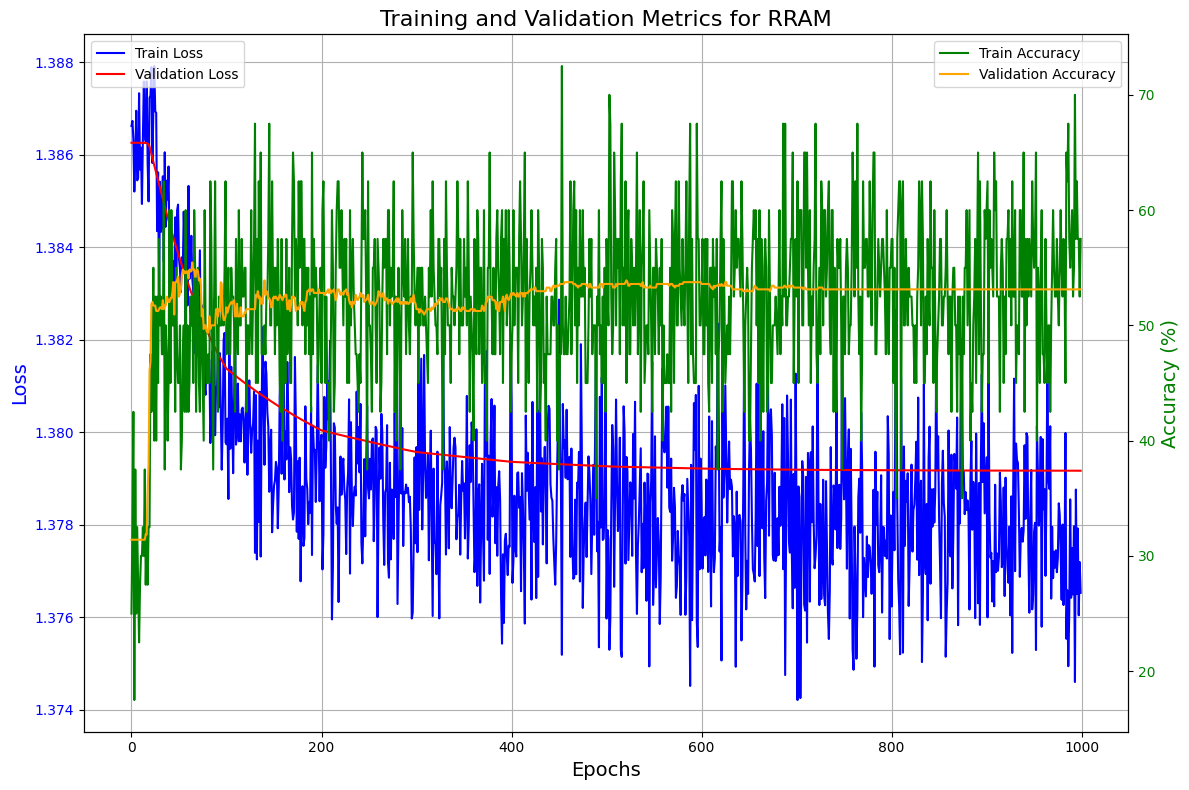

In [316]:
plot_history(history_RRAM, num_epochs, "RRAM")

# Testing Accuracy and Loss:

In [297]:
def test(model, val_inputs, val_labels):
    val_inputs = val_inputs.to(device)
    val_labels = val_labels.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(val_inputs)
        loss = criterion(outputs, val_labels)
        _, predicted = torch.max(outputs, dim=1)
        accuracy = (predicted == val_labels).sum().item() / val_labels.size(0)
    print(f"Validation Loss: {loss.item():.4f}")
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")

In [298]:
test(model_RRAM, val_inputs, val_labels)

Validation Loss: 1.3792
Validation Accuracy: 53.44%


#### Model Stored in Directory:

In [299]:
with open("RRAM_params.txt", 'r') as f: params_RRAM_best = ast.literal_eval(f.read())
print(params_RRAM_best, '\n')
model_RRAM_best = BinaryNeuralNetwork(**params_RRAM_best)
model_RRAM_best.verbose = True
model_RRAM_best.monitor = True
model_RRAM_best.load_state_dict(torch.load("RRAM_model.pth"))
test(model_RRAM_best, val_inputs, val_labels)

{'G_ON': 6e-05, 'G_OFF': 2.88e-06, 'V_INV': 1.2, 'R_INV': 2000.0, 'R_INV2': 100000.0, 'V_1': 0.1, 'V_0': -0.1, 'sharpness': 1000, 'initial_factor': 0.01, 'h_layer': 8, 'verbose': False, 'monitor': False, 'p': 0.3} 



NameError: name 'BinaryNeuralNetwork' is not defined

## PWL Generation

Let's assume that we will program the two crossbars with seperate PWLs. That is, during programming, we will cut the Inverting Amplifier stages with a pass transistor and connect the programming lines with a pass transistor. First array has 16 Top PWLs and 8 Bottom PWLs. Second array has 8 Top PWLs and 4 Bottom PWLs. And then once the programming switch is toggled to inference mode, only the 16 Top PWLs are to be changed. Let's also generate a PWL for that too.

In the code below, we will first maintain tuples for each PWL that holds what the voltage should be. And then we will write a function that will take there and space pulses of the given voltage that are 100us apart from other and have an ON duration of 100us 

In [ ]:
WL_FC1 = [list() for i in range(16)]
BL_FC1 = [list() for i in range(8)]
WL_FC2 = [list() for i in range(8)]
BL_FC2 = [list() for i in range(4)]
Mode = []
Mode_B = []

V_WRITE = 1.5
V_READ = 0.1
V_mode = 1.2

#### Fully Connected Weights 1

In [ ]:
target = (model_RRAM_best.w1>0).int()
target

In [ ]:
for ind_i, i in enumerate(target):
    for ind_j, j in enumerate(i):
        if j==1: WL_FC1[ind_j].append(V_WRITE)
        else: WL_FC1[ind_j].append(V_WRITE/3)
    for ind_k in range(len(target)): 
        if ind_k==ind_i: BL_FC1[ind_i].append(0)
        else: BL_FC1[ind_k].append(2*V_WRITE/3)

#### Fully Connected Weights 2

In [ ]:
target = (model_RRAM_best.w2>0).int()
target

In [ ]:
for ind_i, i in enumerate(target):
    for ind_j, j in enumerate(i):
        if j==1: WL_FC2[ind_j].append(V_WRITE)
        else: WL_FC2[ind_j].append(V_WRITE/3)
    for ind_k in range(len(target)): 
        if ind_k==ind_i: BL_FC2[ind_i].append(0)
        else: BL_FC2[ind_k].append(2*V_WRITE/3)

#### Filling Out Programming Mode

In [ ]:
WL_FC1 = [i + [0,0] for i in WL_FC1]
BL_FC1 = [i + [0,0] for i in BL_FC1]
while(len(WL_FC2[0]) < len(WL_FC1[0])):
    WL_FC2 = [i + [0,] for i in WL_FC2]
    BL_FC2 = [i + [0,] for i in BL_FC2]
Mode.extend([V_mode]*(len(WL_FC1[0])-1) + [-V_mode])
Mode_B.extend([-V_mode]*(len(WL_FC1[0])-1) + [V_mode])

In [ ]:
print(WL_FC1[0])
print(BL_FC1[0])
print(WL_FC2[0])
print(BL_FC2[0])
print(Mode)
print(Mode_B)
print(len(WL_FC1[0]), len(BL_FC1[0]), len(WL_FC2[0]), len(BL_FC2[0]), len(Mode), len(Mode_B)) 

### Inference: Loading the Testing Set

In [ ]:
val_inputs[0]

In [ ]:
V_1 = 0.1
V_0 = -0.1
include_testing = True
include_every = 4

In [ ]:
if include_testing:
    for i in val_inputs[::include_every]:
        i = i.flatten()
        for ind, j in enumerate(i):
            WL_FC1[ind].append(V_1 if j==1 else V_0)
        BL_FC1 = [i + [0,] for i in BL_FC1]
        WL_FC2 = [i + [0,] for i in WL_FC2]
        BL_FC2 = [i + [0,] for i in BL_FC2]
        Mode = Mode + [-V_mode,]
        Mode_B = Mode_B + [V_mode,]

### PWL Convertion

In [ ]:
def pwl(l):
    t = 0
    res = "pwl(time, 0us, 0V"
    for i in l:
        res += f", {t+5}us, {i:.2f}V, {t+100}us, {i:.2f}V, {t+105}us, 0V, {t+200}us, 0V"
        t+=200
    res += ")"
    return res

In [ ]:
pwl_data = []

for ind, i in enumerate(WL_FC1):
    pwl_data.append({"Signal": f"WL_FC1_{ind}", "Index": ind, "PWL": pwl(i)})
for ind, i in enumerate(BL_FC1):
    pwl_data.append({"Signal": f"BL_FC1_{ind}", "Index": ind, "PWL": pwl(i)})
for ind, i in enumerate(WL_FC2):
    pwl_data.append({"Signal": f"WL_FC2_{ind}", "Index": ind, "PWL": pwl(i)})
for ind, i in enumerate(BL_FC2):
    pwl_data.append({"Signal": f"BL_FC2_{ind}", "Index": ind, "PWL": pwl(i)})
pwl_data.append({"Signal": "Mode", "Index": "", "PWL": pwl(Mode)})
pwl_data.append({"Signal": "Mode_b", "Index": "", "PWL": pwl(Mode_B)})

pwl_data = pd.DataFrame(pwl_data)
pwl_data.to_csv("pwl_data.csv", index=False)
pwl_data.head()

#### Testing Accuracy on 160 Images
ADS isn't allowing PWLs longer than 160 Images, so let's check software accuracy for the same too

In [ ]:
test(model_RRAM_best, val_inputs[::4], val_labels[::4])

In [ ]:
test(model_RRAM_best, train_inputs, train_labels)

## Simulation Data from ADS

In [ ]:
simu = pd.read_csv("Testing_160_Images.csv")
simu

In [ ]:
def remove_units(value):
    return float(value.replace('E', 'e').split('V')[0].replace('sec', ''))

simu['time'] = simu['time'].apply(remove_units)
for col in ['A', 'X', 'V', 'T']:
    simu[col] = simu[col].apply(remove_units)
simu

We just need one sample every 0.1ms samples of these starting from 2.050ms to 33.850ms

In [ ]:
t_stamps = np.arange(2.05e-3, 33.9e-3, 0.2e-3)
t_stamps.shape

In [ ]:
sampled = []
window = 0.02e-3

for t in t_stamps:
    filtered = simu[(simu['time'] >= t - window) & (simu['time'] <= t + window)]
    
    avg_A = filtered['A'].mean()
    avg_X = filtered['X'].mean()
    avg_V = filtered['V'].mean()
    avg_T = filtered['T'].mean()
    
    sampled.append({
        'Image Index': t,
        'A': avg_A,
        'X': avg_X,
        'V': avg_V,
        'T': avg_T
    })

sampled = pd.DataFrame(sampled)
sampled

In [ ]:
def get_max_column(row):
    return row[['A', 'X', 'V', 'T']].idxmax()
sampled['Predicted Class'] = sampled.apply(get_max_column, axis=1)
sampled.to_csv("Sampled_Results.csv", index=False)
sampled

In [ ]:
ground_truth = ['A']*40 + ['X']*40 + ['V']*40 + ['T']*40
correct_predictions = sampled['Predicted Class'] == ground_truth
accuracy = correct_predictions.sum() / len(ground_truth)
print(accuracy*100,end="%")

In [ ]:
plt.figure(figsize=(7, 3.5))

plt.scatter(sampled.index, sampled['A'], color='red', label='A_pred', s=30, marker='o')  # Red dots for A
plt.scatter(sampled.index, sampled['X'], color='blue', label='X_pred', s=30, marker='o')  # Blue dots for X
plt.scatter(sampled.index, sampled['T'], color='green', label='T_pred', s=30, marker='o')  # Green dots for T
plt.scatter(sampled.index, sampled['V'], color='orange', label='V_pred', s=30, marker='o')  # Orange dots for V

plt.xlabel('Image Index')
plt.ylabel('Predicted Voltages (V)')
plt.legend()

plt.axvline(x=40, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=80, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=120, color='gray', linestyle='--', linewidth=2)

plt.text(20, plt.ylim()[1]*(-0.8), 'A', fontsize=15, color='black', ha='center')
plt.text(60, plt.ylim()[1]*0.8, 'X', fontsize=15, color='black', ha='center')
plt.text(100, plt.ylim()[1]*0.8, 'V', fontsize=15, color='black', ha='center')
plt.text(140, plt.ylim()[1]*(-0.8), 'T', fontsize=15, color='black', ha='center')

plt.show()

In [ ]:
for epoch in range(num_epochs):
    model_RRAM.train()

    train_loss = 0
    train_accuracy = 0
    total_samples = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_RRAM(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        model_RRAM.backprop(lr)

        train_loss += loss.item() * inputs.size(0)
        _, predictions = torch.max(outputs, dim=1)
        train_accuracy += (predictions == labels).sum().item()
        total_samples += inputs.size(0)

    train_loss /= total_samples
    train_accuracy = (train_accuracy / total_samples) * 100

In [ ]:
def tensor_stats(tensor, name="Tensor"):
    mean_magnitude = tensor.abs().mean().item()
    print(f"{name} - Mean Magnitude: {mean_magnitude:.2e}, Max: {tensor.max().item():.2e}, Min: {tensor.min().item():.2e}")
    
class RecurrentForwardNetwork(nn.Module):
    def __init__(self, G_ON, G_OFF, V_INV, R_INV, V_1, V_0, zeta, initial_factor, 
                 crossbar=(8,8), input_size=16, recurrence_size=4, output_size=4, 
                 hidden_layers=2, verbose=False, monitor=True, dropout=0.2):
        super(RecurrentForwardNetwork, self).__init__()

        # Crossbar Weights
        self.w = nn.Parameter(torch.empty(crossbar, crossbar))
        nn.init.xavier_uniform_(self.w)
        self.w.data = initial_factor * self.w
        
        # Circuit Parameters
        self.G_ON = G_ON
        self.G_OFF = G_OFF
        self.V_INV = V_INV
        self.R_INV = R_INV
        self.V_1 = V_1
        self.V_0 = V_0

        # Architecture Parameters
        self.feedback = recurrence_size
        self.data_in = crossbar[0] - recurrence_size
        self.output_size = output_size
        self.crossbar_in = crossbar[0]
        self.crossbar_out = crossbar[1]
        self.h_layers = hidden_layers
        self.r_passes = input_size // self.data_in
        
        # Training Variables
        self.zeta = zeta
        self.verbose = verbose
        self.monitor = monitor
        self.dropout = nn.Dropout(p=dropout)

    def INV_AMP(self, x):
        return -self.V_INV * torch.tanh(self.R_INV * x / self.V_INV)

    def SOFT_BIN(self, x):
        return ((self.G_ON - self.G_OFF) * torch.sigmoid(x * self.zeta) + self.G_OFF)

    def PREPROCESS(self, img):
        return (self.V_1 - self.V_0) * img.view(img.size(0), -1) + self.V_0

    def forward(self, img):
        # Preprocessing: Two States of input (V_ON and V_OFF)
        img = self.PREPROCESS(img)

        # RRAM Soft Binarization
        g = self.SOFT_BIN(self.w).to(img.device)
        
        if self.verbose:
            print("Latent Weights:", self.w)
            print("Soft Binarized Weights:", g)
        
        # Recurrent Forward Layer
        feedback = self.PREPROCESS(torch.ones((self.feedback,)).to(img.device))
        
        for r_pass in range(self.r_passes):
            x = torch.cat((feedback, img[r_pass * self.data_in:(r_pass + 1) * self.data_in]), dim=0)
            x = F.linear(x, g, bias=False)
            x = self.INV_AMP(x)
            if self.verbose: print(f"Voltages in Recurrent Stage after pass {r_pass}: {x}")
            feedback = x[-self.feedback:]

        x = self.dropout(x)
        
        # Hidden Layers
        for h_pass in range(self.h_layers):
            x = F.linear(x, g, bias=False)
            x = self.INV_AMP(x)
            x = self.dropout(x)  # Apply dropout within the hidden layers
            if self.verbose: print(f"Voltages after h_layer {h_pass}: {x}")

        # Output Classes
        return x[:self.output_size]
        
    def backprop(self, lr):
        if self.verbose:
            print("Latent Gradients:", lr * self.w.grad if self.w.grad is not None else None)
    
        with torch.no_grad():
            if self.w.grad is not None:
                self.w -= lr * self.w.grad
                self.w.grad.zero_()